# Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, clear_output, HTML
import ipywidgets as widgets
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
from collections import Counter
import re
import csv
import xml.etree.ElementTree as ET
import ast
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoModel
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
import torch
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import evaluate
from torch.utils.data import Dataset, DataLoader
import warnings
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import joblib

# Check if GPU is available

In [2]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using GPU: Tesla V100-SXM2-16GB


In [5]:
from epo.tipdata.epab import EPABClient
#For test database (10K)
#epab = EPABClient(env='TEST')

#For the complete database
epab = EPABClient(env='PROD')

In [6]:
epab.fields()

WidDatabaseFields(header='', input_data={'': [{'name': 'epab_doc_id', 'type': 'STRING', 'mode': 'REQUIRED', 'd…

In [7]:
q = epab.query_publication(number="%", kind_code="B1", date="20200101-20240131", language='EN')
print ('Total query:', q)

Total query: 350041 publications


In [8]:
result = q.get_results("publication.number, ipc, claims",limit = 200000)
df = pd.DataFrame(result)
csv_file = "q_results_output.csv"
df.to_csv(csv_file)
print(f"All data fetched and saved to {csv_file} successfully.")

All data fetched and saved to q_results_output.csv successfully.


In [9]:
# Read the CSV file
df = pd.read_csv('q_results_output.csv')

# Replace '.' with '_' in the column headers
df.columns = df.columns.str.replace('.', '_', regex=False)

# Save the DataFrame with updated column names back to the original file
df.to_csv('q_results_output.csv', index=False)

# Display the updated column names
print(df.columns)

# Display the total number of rows (data entries)
total_rows = df.shape[0]
print(f"Total number of data rows: {total_rows}")


Index(['Unnamed: 0', 'publication_number', 'ipc', 'claims'], dtype='object')
Total number of data rows: 200000


In [10]:
# Load the CSV file
df = pd.read_csv('q_results_output.csv')
print(df.columns)

Index(['Unnamed: 0', 'publication_number', 'ipc', 'claims'], dtype='object')


In [ ]:
# Specify the columns you want to keep
selected_columns = ['publication_number', 'ipc', 'claims']

# Check if the columns exist in the DataFrame
existing_columns = [col for col in selected_columns if col in df.columns]

# Filter the DataFrame to keep only the selected columns
filtered_df = df[existing_columns]

# Specify the output file name and the save directory
output_file_name = 'selected_columns_output.csv'
save_directory = './'

# Ensure the directory exists
os.makedirs(save_directory, exist_ok=True)

# Set the full path for saving the CSV file
full_path = os.path.join(save_directory, output_file_name)

# Save the filtered DataFrame to a new CSV file
filtered_df.to_csv(full_path, index=False)

# Print the file path for confirmation
print(f"CSV file '{output_file_name}' generated and saved to: {full_path}")

# Optionally, preview the first few rows of the new CSV file
print("\nPreview of the generated CSV file:")
print(filtered_df.head())


CSV file 'selected_columns_output.csv' generated and saved to: ./selected_columns_output.csv

Preview of the generated CSV file:
   publication_number                                                ipc  \
0             3137169  [{'version': '8', 'symbol': 'A61P35/00', 'cate...   
1             3202161  [{'version': '8', 'symbol': 'H04R25/00', 'cate...   
2             3291978  [{'version': '8', 'symbol': 'B31B70/00', 'cate...   
3             3240556  [{'version': '8', 'symbol': 'A61K35/747', 'cat...   
4             3262762  [{'version': '8', 'symbol': 'H03M1/00', 'categ...   

                                              claims  
0  [{'language': 'EN', 'text': '<claim id="c-en-0...  
1  [{'language': 'EN', 'text': '<claim id="c-en-0...  
2  [{'language': 'EN', 'text': '<claim id="c-en-0...  
3  [{'language': 'EN', 'text': '<claim id="c-en-0...  
4  [{'language': 'EN', 'text': '<claim id="c-en-0...  


In [ ]:
# Read the CSV file
df = pd.read_csv('selected_columns_output.csv')

# Function to filter claims for English language
def filter_english_claims(claims):
    claims_list = ast.literal_eval(claims)  # Convert string representation to list of dictionaries
    # Filter the claims for language 'EN'
    english_claims = [claim for claim in claims_list if claim['language'] == 'EN']
    return english_claims

# Apply the filter function to the 'claims' column
df['english_claims'] = df['claims'].apply(filter_english_claims)

# Replace the 'claims' column with 'english_claims' data
df['claims'] = df['english_claims']

# Optionally drop the 'english_claims' column if no longer needed
df = df.drop(columns=['english_claims'])

# Save the modified DataFrame to 'filtered_english_claims.csv'
df.to_csv('filtered_english_claims.csv', index=False)

# Display the modified DataFrame (optional)
print(df)


        publication_number                                                ipc  \
0                  3137169  [{'version': '8', 'symbol': 'A61P35/00', 'cate...   
1                  3202161  [{'version': '8', 'symbol': 'H04R25/00', 'cate...   
2                  3291978  [{'version': '8', 'symbol': 'B31B70/00', 'cate...   
3                  3240556  [{'version': '8', 'symbol': 'A61K35/747', 'cat...   
4                  3262762  [{'version': '8', 'symbol': 'H03M1/00', 'categ...   
...                    ...                                                ...   
199995             3178228  [{'version': '8', 'symbol': 'H04N19/50', 'cate...   
199996             3274923  [{'version': '8', 'symbol': 'G06V10/42', 'cate...   
199997             3274292  [{'version': '8', 'symbol': 'B81B7/00', 'categ...   
199998             2827772  [{'version': '8', 'symbol': 'A61B5/055', 'cate...   
199999             3281199  [{'version': '8', 'symbol': 'G10L19/26', 'cate...   

                           

In [ ]:
# Define the file path
file_path = 'filtered_english_claims.csv'

# Check if the file exists
if os.path.exists(file_path):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Display the first three rows in an interactive DataTable
    table_widget = widgets.Output()
    with table_widget:
        display(df.head(3))

    display(table_widget)
else:
    print(f"The file {file_path} does not exist.")

Output()

In [ ]:
# Function to clean the 'IPC' column
def clean_ipc_column(ipc_data):
    try:
        # Convert string representation of list to actual list of dictionaries
        ipc_list = ast.literal_eval(ipc_data)
        
        # Extract and clean the 'symbol', removing unwanted characters except alphanumeric and '/'
        cleaned_ipc = [re.sub(r'[^A-Za-z0-9/]', '', entry['symbol']) for entry in ipc_list]
        
        # Join cleaned symbols into a single string, separated by commas
        return ', '.join(cleaned_ipc)
    except (ValueError, SyntaxError, KeyError):
        # If any error occurs during the processing, return the original data
        return ipc_data

# Example usage:
df['cleaned_ipc'] = df['ipc'].apply(clean_ipc_column)


In [ ]:
# Function to clean the 'Claims' column and convert to lowercase
def clean_claims_column(claims_data):
    try:
        # Convert string representation to a list of dictionaries
        claims_list = ast.literal_eval(claims_data)
        
        # Extract and clean the 'text' field where the language is 'EN'
        for claim in claims_list:
            if claim.get('language') == 'EN':
                # Remove HTML tags and claim numbers
                cleaned_claims = re.sub(r'<.*?>', '', claim['text'])  # Remove HTML tags
                cleaned_claims = re.sub(r'\b\d+\.\s', '', cleaned_claims)  # Remove claim numbers like 1., 2., etc.
                
                # Remove unwanted special characters but keep commas, periods, and question marks
                cleaned_claims = re.sub(r'[^a-zA-Z0-9,.?\s]', '', cleaned_claims)
                
                # Remove newline characters
                cleaned_claims = cleaned_claims.replace('\n', '')

                # Convert the cleaned claims to lowercase
                cleaned_claims = cleaned_claims.lower()

                return cleaned_claims.strip()  # Return cleaned and lowercased text with extra spaces removed
                
        # Return original data if no 'EN' claims found
        return claims_data
    
    except (ValueError, SyntaxError, KeyError):
        # Return original data if any error occurs
        return claims_data


In [ ]:
# Function to clean the 'description_text' column
def clean_description_column(description_text):
    if not isinstance(description_text, str):
        description_text = ''  # Convert non-string or NaN to an empty string
    cleaned_description = re.sub(r'<.*?>', '', description_text)  # Remove all HTML-like tags
    cleaned_description = re.sub(r'\s+', ' ', cleaned_description).strip()  # Clean up extra spaces and new lines
    return cleaned_description

In [ ]:
# Function to clean the abstract column 
def clean_abstract_column(abstract_text):
    if not isinstance(abstract_text, str):
        return ''  # Return empty string if the input is not a valid string
    
    # Step 1: Remove image tags and their associated metadata like <img ... />
    cleaned_abstract = re.sub(r'<img.*?>', '', abstract_text)

    # Step 2: Remove all other HTML tags like <p>, <ul>, <li>, <br>, etc.
    cleaned_abstract = re.sub(r'<.*?>', ' ', cleaned_abstract)

    # Step 3: Remove list-related numbering like (1), (2), (3), etc. and also numbers with dots 1., 2., 3., etc.
    cleaned_abstract = re.sub(r'\(\d+\)', '', cleaned_abstract)  # Remove list numbering like (1), (2), etc.
    cleaned_abstract = re.sub(r'\b\d+\.\s', '', cleaned_abstract)  # Remove numbering like 1. 2. etc.
    
    # Step 4: Remove extra whitespace and newlines
    cleaned_abstract = re.sub(r'\s+', ' ', cleaned_abstract).strip()

    return cleaned_abstract


In [ ]:
# Define the file paths
input_file_path = 'filtered_english_claims.csv'
output_file_path = 'cleaned_columns_output.csv'

# Set the chunk size for reading and processing the CSV file
chunk_size = 5000

# Process the CSV file in chunks
chunks = pd.read_csv(input_file_path, chunksize=chunk_size)

# Initialize the output CSV file with headers from the first chunk
header_written = False

for chunk in chunks:
    # Apply the cleaning functions to the relevant columns
    chunk['ipc'] = chunk['ipc'].apply(clean_ipc_column)
    chunk['claims'] = chunk['claims'].apply(clean_claims_column)

    # Optionally add additional cleaning for 'description_text' and 'abstract_text'
    # chunk['description_text'] = chunk['description_text'].apply(clean_description_column)
    # chunk['abstract_text'] = chunk['abstract_text'].apply(clean_abstract_column)

    # Keep only the 'ipc' and 'claims' columns
    chunk = chunk[['publication_number', 'ipc', 'claims']]

    # Write the cleaned chunk to the output CSV file
    if not header_written:
        chunk.to_csv(output_file_path, index=False, mode='w')
        header_written = True
    else:
        chunk.to_csv(output_file_path, index=False, mode='a', header=False)

# Print a success message
print(f"Cleaned data saved successfully to {output_file_path}!")

Cleaned data saved successfully to cleaned_columns_output.csv!


In [ ]:
# Define the file path
file_path = 'cleaned_columns_output.csv'

# Check if the file exists
if os.path.exists(file_path):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Display the first three rows in an interactive DataTable
    table_widget = widgets.Output()
    with table_widget:
        display(df.head(20))

    display(table_widget)
else:
    print(f"The file {file_path} does not exist.")

Output()

In [29]:
# Load the cleaned dataset
file_path = 'cleaned_columns_output.csv'
df = pd.read_csv(file_path)

# Display the shape of the loaded dataset to verify
print(f"Loaded {df.shape[0]} rows from the dataset.")

# Save the accumulated data to 'even_data_distribution.csv'
output_file_path = 'random_data_distribution.csv'
df.to_csv(output_file_path, index=False)


Loaded 200000 rows from the dataset.


In [30]:
# Extract the IPC section (first letter of the IPC code)
df['ipc_section'] = df['ipc'].apply(lambda x: x[0] if pd.notna(x) and len(x) > 0 else '')

# Count the number of rows for each IPC section
section_counts = df['ipc_section'].value_counts()

# Print the counts for each section
print("Data count per section:")
print(section_counts)

Data count per section:
ipc_section
H    49056
G    36962
A    34921
B    30612
C    23606
F    17855
E     4807
D     2181
Name: count, dtype: int64


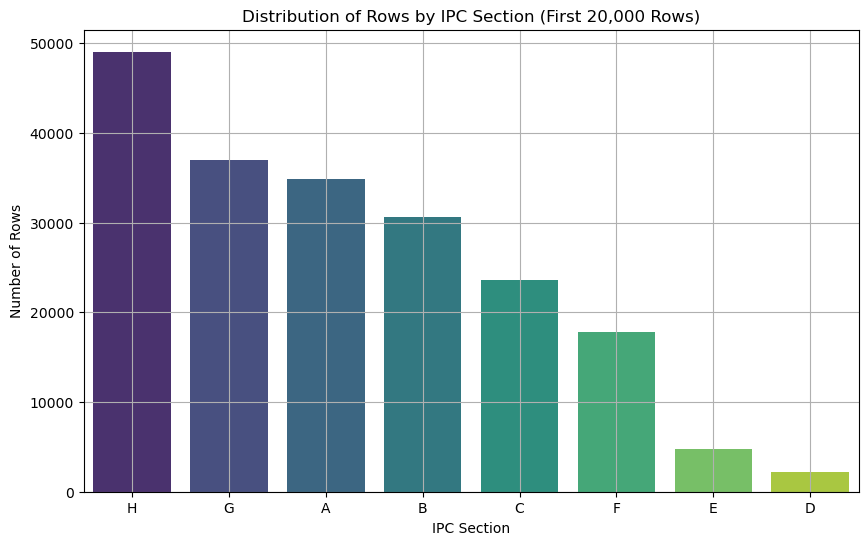

In [31]:
# Plot the distribution of rows per section
plt.figure(figsize=(10, 6))
sns.barplot(x=section_counts.index, y=section_counts.values, hue=section_counts.index, palette='viridis', dodge=False, legend=False)
plt.title('Distribution of Rows by IPC Section (First 20,000 Rows)')
plt.xlabel('IPC Section')
plt.ylabel('Number of Rows')
plt.grid(True)
plt.show()


In [32]:
file_path = 'random_data_distribution.csv'

# Check if the file exists
if os.path.exists(file_path):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Display few rows in an interactive DataTable
    table_widget = widgets.Output()
    with table_widget:
        display(df.head(20))

    display(table_widget)
else:
    print(f"The file {file_path} does not exist.")

Output()

In [33]:
# Load the dataset
#file_path = 'even_data_distribution.csv' # For even dataset
file_path = 'random_data_distribution.csv' # For random dataset
df = pd.read_csv(file_path)

# Convert 'ipc' column to string type to avoid TypeError
df['ipc'] = df['ipc'].astype(str)

# Split the dataset into training and evaluation sets (e.g., 80% for training and 20% for evaluation)
train_df, eval_df = train_test_split(df, test_size=0.1, random_state=42)

# Save the training and evaluation datasets to new CSV files
train_file_path = 'train_dataset.csv'
eval_file_path = 'eval_dataset.csv'

train_df.to_csv(train_file_path, index=False)
eval_df.to_csv(eval_file_path, index=False)

# Print success message
print(f"Training dataset saved to {train_file_path}")
print(f"Evaluation dataset saved to {eval_file_path}")

# Optionally, display the sizes of the datasets to verify the split
print(f"Training dataset size: {train_df.shape[0]} rows")
print(f"Evaluation dataset size: {eval_df.shape[0]} rows")

Training dataset saved to train_dataset.csv
Evaluation dataset saved to eval_dataset.csv
Training dataset size: 180000 rows
Evaluation dataset size: 20000 rows


In [34]:
# Load the new dataset and display it
new_file_path = 'train_dataset.csv'
df = pd.read_csv(new_file_path)
print(df.head())

# Analyze the data
print("\nData Information:\n")
print(df.info())

   publication_number                                                ipc  \
0             3668915                                          C08G65/26   
1             2609572                                G06T7/00, G06T11/00   
2             3456562                                B60H1/00, F24F13/14   
3             3167953  B01D69/10, B01D69/12, B01D71/02, C01B39/48, B0...   
4             3261715                                A61N1/37, A61N1/365   

                                              claims  
0  a method of preparing a monoc432 hydrocarbyl e...  
1  a method comprisinggenerating 124 an attenuati...  
2  a mechanism 10 for mutually connecting a first...  
3  a method of producing a zeolite membrane havin...  
4  an implantable medical device, comprisingan ac...  

Data Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              ---------

In [35]:
# Example: Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values in Each Column:\n")
print(missing_values)


Missing Values in Each Column:

publication_number    0
ipc                   0
claims                0
dtype: int64


In [36]:
# Load the evaluation dataset
eval_file_path = 'eval_dataset.csv'
eval_df = pd.read_csv(eval_file_path)

# Check if the 'ipc' column exists
if 'ipc' in eval_df.columns:
    # Ensure the 'ipc' column is treated as a string, even if it's not
    eval_df['ipc'] = eval_df['ipc'].astype(str)

    # Extract the IPC section from the 'ipc' column (first character)
    eval_df['ipc_section'] = eval_df['ipc'].apply(lambda x: x[0] if pd.notna(x) and len(x) > 0 else '')
    
    # Verify the 'ipc_section' column was created correctly
    print("First few rows of 'ipc_section' column:")
    print(eval_df[['ipc', 'ipc_section']].head())

    # Save the updated dataset back to the original file (overwriting it)
    eval_df.to_csv(eval_file_path, index=False)
    
    print(f"IPC sections added successfully and saved back to {eval_file_path}")
else:
    print("Error: The 'ipc' column is missing from the dataset.")


First few rows of 'ipc_section' column:
                                                 ipc ipc_section
0  A23J1/00, C07K1/22, C07K16/00, C07K17/00, G01N...           A
1  G01S7/03, H01Q21/08, G01S13/42, G01S13/34, G01...           G
2  H01R13/52, H01R13/6581, H05K5/02, H01R12/72, H...           H
3  C10L1/224, C10L10/04, C10L10/06, C10L10/08, C1...           C
4                              A61K39/395, C07K16/28           A
IPC sections added successfully and saved back to eval_dataset.csv


In [37]:
eval_file_path = 'eval_dataset.csv'
eval_df = pd.read_csv(eval_file_path)
print(eval_df.columns)

Index(['publication_number', 'ipc', 'claims', 'ipc_section'], dtype='object')


# Training the Model

## Step 1: Load the training dataset

In [3]:
train_file_path = 'train_dataset.csv'
df = pd.read_csv(train_file_path)

## Step 2: Extract Sections, Classes and Subclasses from IPC codes and encode them

In [4]:
df['ipc'] = df['ipc'].astype(str)
df['ipc_section'] = df['ipc'].apply(lambda x: x[0] if len(x) > 0 else '')
df['ipc_class'] = df['ipc'].apply(lambda x: x[:3] if len(x) >= 3 else '')
df['ipc_subclass'] = df['ipc'].apply(lambda x: x[:4] if len(x) >= 4 else '')

# Encode sections, classes, and subclasses
label_encoder_section = LabelEncoder()
label_encoder_class = LabelEncoder()
label_encoder_subclass = LabelEncoder()

df['encoded_section'] = label_encoder_section.fit_transform(df['ipc_section'])
df['encoded_class'] = label_encoder_class.fit_transform(df['ipc_class'])
df['encoded_subclass'] = label_encoder_subclass.fit_transform(df['ipc_subclass'])

# Print DataFrame columns to verify 'encoded_section' is present
print(df.columns)

# Check the first few rows of the DataFrame
print(df.head())


Index(['publication_number', 'ipc', 'claims', 'ipc_section', 'ipc_class',
       'ipc_subclass', 'encoded_section', 'encoded_class', 'encoded_subclass'],
      dtype='object')
   publication_number                                                ipc  \
0             3668915                                          C08G65/26   
1             2609572                                G06T7/00, G06T11/00   
2             3456562                                B60H1/00, F24F13/14   
3             3167953  B01D69/10, B01D69/12, B01D71/02, C01B39/48, B0...   
4             3261715                                A61N1/37, A61N1/365   

                                              claims ipc_section ipc_class  \
0  a method of preparing a monoc432 hydrocarbyl e...           C       C08   
1  a method comprisinggenerating 124 an attenuati...           G       G06   
2  a mechanism 10 for mutually connecting a first...           B       B60   
3  a method of producing a zeolite membrane havin...   

## See the Encoded Data and Mapping

In [5]:
# To see the mapping of encoded values to original IPC codes, you can also print the mapping:
print("\nMapping for IPC Sections (Label -> Original):")
print(dict(enumerate(label_encoder_section.classes_)))

print("\nMapping for IPC Classes (Label -> Original):")
print(dict(enumerate(label_encoder_class.classes_)))

print("\nMapping for IPC Subclasses (Label -> Original):")
print(dict(enumerate(label_encoder_subclass.classes_)))


Mapping for IPC Sections (Label -> Original):
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H'}

Mapping for IPC Classes (Label -> Original):
{0: 'A01', 1: 'A21', 2: 'A22', 3: 'A23', 4: 'A24', 5: 'A41', 6: 'A42', 7: 'A43', 8: 'A44', 9: 'A45', 10: 'A46', 11: 'A47', 12: 'A61', 13: 'A62', 14: 'A63', 15: 'B01', 16: 'B02', 17: 'B03', 18: 'B04', 19: 'B05', 20: 'B06', 21: 'B07', 22: 'B08', 23: 'B09', 24: 'B21', 25: 'B22', 26: 'B23', 27: 'B24', 28: 'B25', 29: 'B26', 30: 'B27', 31: 'B28', 32: 'B29', 33: 'B30', 34: 'B31', 35: 'B32', 36: 'B33', 37: 'B41', 38: 'B42', 39: 'B43', 40: 'B44', 41: 'B60', 42: 'B61', 43: 'B62', 44: 'B63', 45: 'B64', 46: 'B65', 47: 'B66', 48: 'B67', 49: 'B68', 50: 'B81', 51: 'B82', 52: 'C01', 53: 'C02', 54: 'C03', 55: 'C04', 56: 'C05', 57: 'C06', 58: 'C07', 59: 'C08', 60: 'C09', 61: 'C10', 62: 'C11', 63: 'C12', 64: 'C13', 65: 'C14', 66: 'C21', 67: 'C22', 68: 'C23', 69: 'C25', 70: 'C30', 71: 'C40', 72: 'D01', 73: 'D02', 74: 'D03', 75: 'D04', 76: 'D05', 77: 

## Visualize the distribution of IPC sections

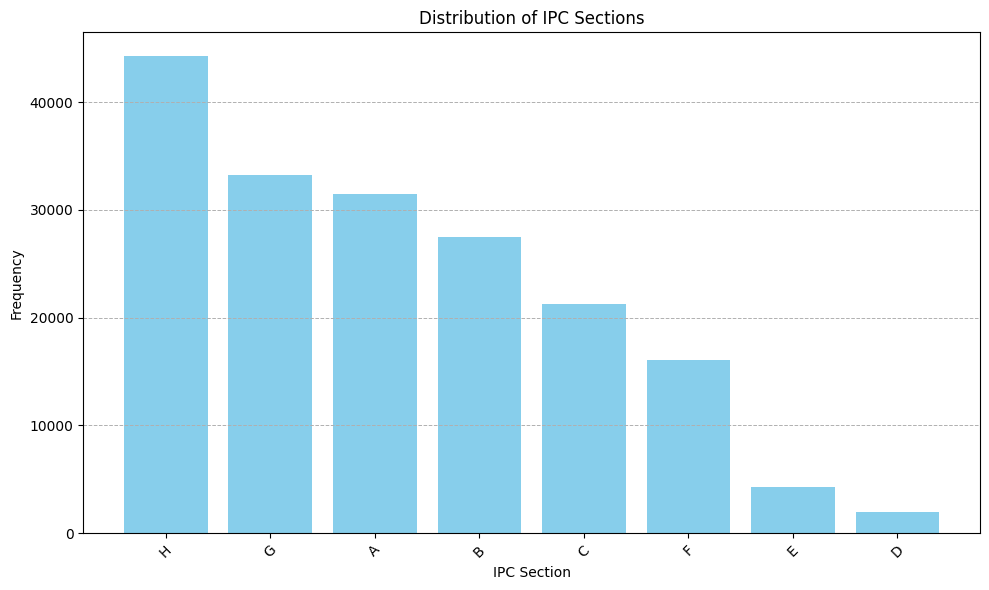

In [6]:
section_counts = df['ipc_section'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(section_counts.index, section_counts.values, color='skyblue')
plt.xlabel('IPC Section')
plt.ylabel('Frequency')
plt.title('Distribution of IPC Sections')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

# Train for Section Prediction

Number of Encoded sections: 8
Fold 1 completed and checkpoint saved.
Fold 2 completed and checkpoint saved.
Fold 3 completed and checkpoint saved.
Fold 4 completed and checkpoint saved.
Fold 5 completed and checkpoint saved.


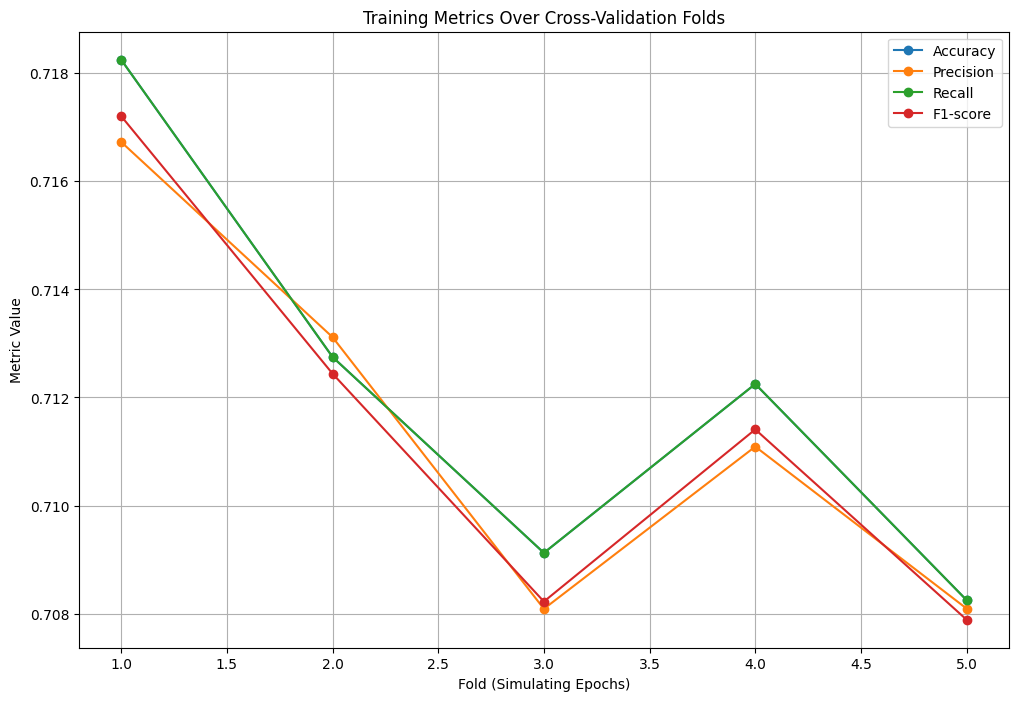

Test Accuracy: 0.7251
Test Precision: 0.7258465041940196
Test Recall: 0.7251
Test F1-score: 0.724829839838029
              precision    recall  f1-score   support

           A       0.76      0.73      0.75      1710
           B       0.64      0.64      0.64      1523
           C       0.72      0.77      0.75      1221
           D       0.68      0.52      0.59       101
           E       0.64      0.49      0.56       248
           F       0.72      0.71      0.71       874
           G       0.67      0.71      0.69      1832
           H       0.81      0.80      0.80      2491

    accuracy                           0.73     10000
   macro avg       0.71      0.67      0.69     10000
weighted avg       0.73      0.73      0.72     10000



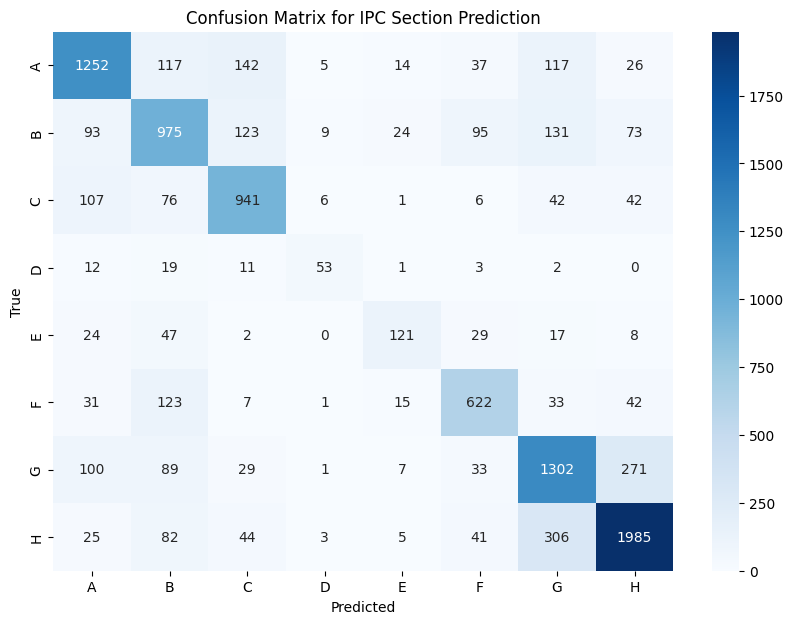

Model saved to Models/ipc_section_classifier.pkl
Label encoder saved to Models/ipc_section_label_encoder.pkl


In [7]:
# Load the dataset (limit to 50,000 rows)
file_path = 'train_dataset.csv'
df = pd.read_csv(file_path, nrows=50000)

# Initialize the SentenceTransformer model
model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')

# Remove rows where the 'claims' column is empty (NaN or empty string)
df = df[df['claims'].notna() & (df['claims'].str.strip() != '')]

# Extract the first letter of the IPC code for section prediction
df['ipc_section'] = df['ipc'].apply(lambda x: x[0] if pd.notna(x) and len(x) > 0 else '')

# Encode labels for IPC section
label_encoder_section = LabelEncoder()
df['encoded_section'] = label_encoder_section.fit_transform(df['ipc_section'])

num_sections = len(label_encoder_section.classes_)
print("Number of Encoded sections:", num_sections)

# Train/test split (for section prediction as an example)
X_train, X_test, y_train, y_test = train_test_split(df['claims'], df['encoded_section'], test_size=0.2, random_state=42)

# Encode the claims into embeddings using PatentSBERTa
X_train_embeddings = model.encode(X_train.tolist())
X_test_embeddings = model.encode(X_test.tolist())

# Convert embeddings to NumPy arrays
X_train_embeddings = np.array(X_train_embeddings)
X_test_embeddings = np.array(X_test_embeddings)

# Save the embeddings to disk using joblib memory mapping
X_train_embeddings_file = 'X_train_embeddings_memmapped.pkl'
X_test_embeddings_file = 'X_test_embeddings_memmapped.pkl'
joblib.dump(X_train_embeddings, X_train_embeddings_file)
joblib.dump(X_test_embeddings, X_test_embeddings_file)

# Load the embeddings back as memory-mapped files
X_train_embeddings = joblib.load(X_train_embeddings_file, mmap_mode='r')
X_test_embeddings = joblib.load(X_test_embeddings_file, mmap_mode='r')

# Train a simple classifier (e.g., Logistic Regression) on the embeddings
classifier = LogisticRegression(max_iter=1000)

# Cross-validation to simulate training in folds (like epochs)
skf = StratifiedKFold(n_splits=5)

# Initialize lists to store metrics for each fold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Checkpoint file paths
checkpoint_classifier_file = 'Models/checkpoint_ipc_section_classifier.pkl'
checkpoint_metrics_file = 'Models/checkpoint_metrics.pkl'
checkpoint_fold_file = 'Models/checkpoint_current_fold.pkl'

# Load checkpoints if available
current_fold = 0
if os.path.exists(checkpoint_fold_file):
    current_fold = joblib.load(checkpoint_fold_file)
    accuracy_list, precision_list, recall_list, f1_list = joblib.load(checkpoint_metrics_file)
    classifier = joblib.load(checkpoint_classifier_file)
    print(f"Resuming from fold {current_fold + 1}")

# Train and evaluate the model for each fold
for fold, (train_index, test_index) in enumerate(skf.split(X_train_embeddings, y_train)):
    if fold < current_fold:
        continue  # Skip already completed folds
    
    X_train_fold, X_test_fold = X_train_embeddings[train_index], X_train_embeddings[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]  # Use .iloc[] for positional indexing

    classifier.fit(X_train_fold, y_train_fold)
    y_pred_fold = classifier.predict(X_test_fold)
    
    # Calculate metrics for the current fold
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    precision = precision_score(y_test_fold, y_pred_fold, average='weighted')
    recall = recall_score(y_test_fold, y_pred_fold, average='weighted')
    f1 = f1_score(y_test_fold, y_pred_fold, average='weighted')

    # Append metrics to lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    # Save checkpoints after each fold
    joblib.dump(classifier, checkpoint_classifier_file)
    joblib.dump([accuracy_list, precision_list, recall_list, f1_list], checkpoint_metrics_file)
    joblib.dump(fold, checkpoint_fold_file)

    print(f"Fold {fold + 1} completed and checkpoint saved.")

# Visualizing Metrics
epochs = range(1, len(accuracy_list) + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs, accuracy_list, label='Accuracy', marker='o')
plt.plot(epochs, precision_list, label='Precision', marker='o')
plt.plot(epochs, recall_list, label='Recall', marker='o')
plt.plot(epochs, f1_list, label='F1-score', marker='o')
plt.xlabel('Fold (Simulating Epochs)')
plt.ylabel('Metric Value')
plt.title('Training Metrics Over Cross-Validation Folds')
plt.legend()
plt.grid(True)
plt.show()

# Final evaluation on the test set
classifier.fit(X_train_embeddings, y_train)
y_pred = classifier.predict(X_test_embeddings)

# Compute final metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1-score: {f1}")

# Classification report
print(classification_report(y_test, y_pred, target_names=label_encoder_section.classes_))

# Confusion matrix for final evaluation
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder_section.classes_, yticklabels=label_encoder_section.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for IPC Section Prediction')
plt.show()

# Save the final classifier
classifier_file_path = 'Models/ipc_section_classifier.pkl'
joblib.dump(classifier, classifier_file_path)

# Save the label encoder for the IPC sections
label_encoder_file_path = 'Models/ipc_section_label_encoder.pkl'
joblib.dump(label_encoder_section, label_encoder_file_path)

# Remove the checkpoint files
if os.path.exists(checkpoint_fold_file):
    os.remove(checkpoint_fold_file)
if os.path.exists(checkpoint_classifier_file):
    os.remove(checkpoint_classifier_file)
if os.path.exists(checkpoint_metrics_file):
    os.remove(checkpoint_metrics_file)

print(f"Model saved to {classifier_file_path}")
print(f"Label encoder saved to {label_encoder_file_path}")


In [8]:
# Load the trained model and encoders
classifier = joblib.load('Models/ipc_section_classifier.pkl')
label_encoder_section = joblib.load('Models/ipc_section_label_encoder.pkl')

# Load the evaluation dataset
eval_file_path = 'eval_dataset.csv'
eval_df = pd.read_csv(eval_file_path)

# Initialize the SentenceTransformer model (PatentSBERTa)
model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')

# Remove rows where the 'claims' column is empty (NaN or empty string)
eval_df = eval_df[eval_df['claims'].notna() & (eval_df['claims'].str.strip() != '')]

# Encode the 'claims' from eval_dataset.csv into embeddings
eval_claims_embeddings = model.encode(eval_df['claims'].tolist())

# Use the trained classifier to predict the IPC section
predicted_encoded_sections = classifier.predict(eval_claims_embeddings)

# Decode the predicted sections back to their original IPC section format
predicted_sections = label_encoder_section.inverse_transform(predicted_encoded_sections)

# Add the predicted sections and check if predictions are correct
eval_df['predicted_section'] = predicted_sections
eval_df['correct_prediction'] = eval_df['predicted_section'] == eval_df['ipc_section']

# Display the DataFrame showing publication_number, ipc, claims, actual ipc_section, and predicted_section
result_df = eval_df[['publication_number', 'ipc', 'claims', 'ipc_section', 'predicted_section', 'correct_prediction']]

# Display the DataFrame with the results
print(result_df.head(10))  # Show first 10 rows

# Calculate and display the accuracy
correct_predictions = result_df['correct_prediction'].sum()
total_predictions = len(result_df)
accuracy = correct_predictions / total_predictions

print(f"\nTotal predictions: {total_predictions}")
print(f"Correct predictions: {correct_predictions}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Save the result to a new CSV file
result_file_path = 'predicted_eval_dataset.csv'
result_df.to_csv(result_file_path, index=False)

print(f"\nResults saved to {result_file_path}")

# Optional: Show the first 10 rows of the saved file
result_df.head(100)


   publication_number                                                ipc  \
0             3048899  A23J1/00, C07K1/22, C07K16/00, C07K17/00, G01N...   
1             3060940  G01S7/03, H01Q21/08, G01S13/42, G01S13/34, G01...   
2             3751677  H01R13/52, H01R13/6581, H05K5/02, H01R12/72, H...   
3             3887488  C10L1/224, C10L10/04, C10L10/06, C10L10/08, C1...   
4             3268037                              A61K39/395, C07K16/28   
5             3569771                      E02F3/32, E02F9/20, G05G9/047   
6             3401761                      H04L12/28, G06F3/16, G06F3/01   
7             3448922  C08J3/20, C09D5/34, C09D183/06, C09D183/08, B0...   
8             3738946             C07C7/00, C07C7/04, C07C7/12, C07C9/15   
9             3595293                               H04N5/357, H04N5/378   

                                              claims ipc_section  \
0  a method of inactivating virus present during ...           A   
1  a radar apparatus for es

,publication_number,ipc,claims,ipc_section,predicted_section,correct_prediction
0,3048899,"A23J1/00, C07K1/22, C07K16/00, C07K17/00, G01N...",a method of inactivating virus present during ...,A,C,False
1,3060940,"G01S7/03, H01Q21/08, G01S13/42, G01S13/34, G01...",a radar apparatus for estimating position of a...,G,G,True
2,3751677,"H01R13/52, H01R13/6581, H05K5/02, H01R12/72, H...",an electronic component unit 1 comprisinga cir...,H,H,True
3,3887488,"C10L1/224, C10L10/04, C10L10/06, C10L10/08, C1...","a fuel composition comprisingi a liquid fuel, ...",C,C,True
4,3268037,"A61K39/395, C07K16/28",a cd27 agonist comprising a first component th...,A,C,False
...,...,...,...,...,...,...
95,3140981,"H04L29/08, H04L12/24","a method, comprisingreceiving, by a computing ...",H,H,True
96,2554199,"A61M5/178, A61M5/31, A61M5/315",a drug administration device 1 for administrat...,A,A,True
97,3312339,"D21H11/00, D21H13/00, D21H17/33, D21H17/37, D0...",a gypsum board comprising a gypsum core with a...,D,D,True
98,3376070,"F16H55/24, F16H57/022, F16H57/021, F16H57/12, ...",a method for manufacturing a worm reducer 1 in...,F,B,False


# Train For IPC Class Prediction

Number of Encoded Classes: 123
Resuming from fold 5


/home/sahaarnab013/.conda/envs/testenv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/sahaarnab013/.conda/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 5 completed and checkpoint saved.


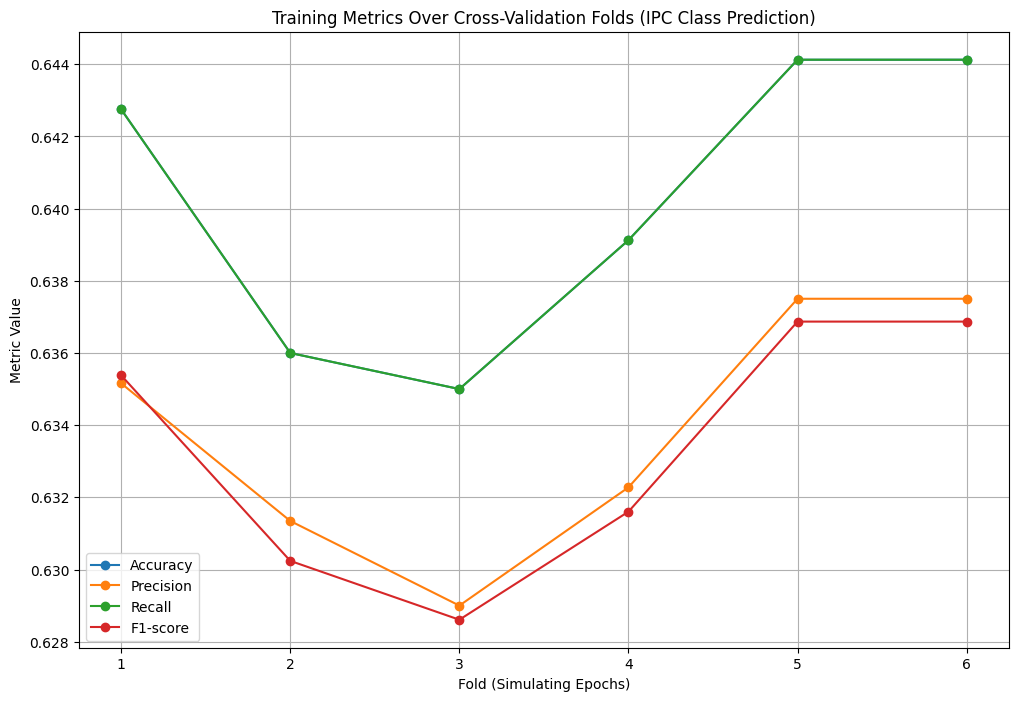

/home/sahaarnab013/.conda/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sahaarnab013/.conda/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sahaarnab013/.conda/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capit

Test Accuracy: 0.653
Test Precision: 0.6488283785782148
Test Recall: 0.653
Test F1-score: 0.647101769841701
              precision    recall  f1-score   support

         A01       0.64      0.54      0.59       118
         A21       0.00      0.00      0.00         5
         A22       1.00      0.12      0.22         8
         A23       0.61      0.64      0.62        47
         A24       0.79      0.73      0.76        56
         A41       0.71      0.42      0.53        12
         A42       1.00      0.71      0.83         7
         A43       0.93      0.82      0.87        33
         A44       0.50      0.25      0.33         4
         A45       0.56      0.42      0.48        24
         A46       0.71      0.56      0.62         9
         A47       0.58      0.64      0.61       121
         A61       0.75      0.80      0.77      1204
         A62       0.50      0.32      0.39        19
         A63       0.56      0.44      0.49        43
         B01       0.37    

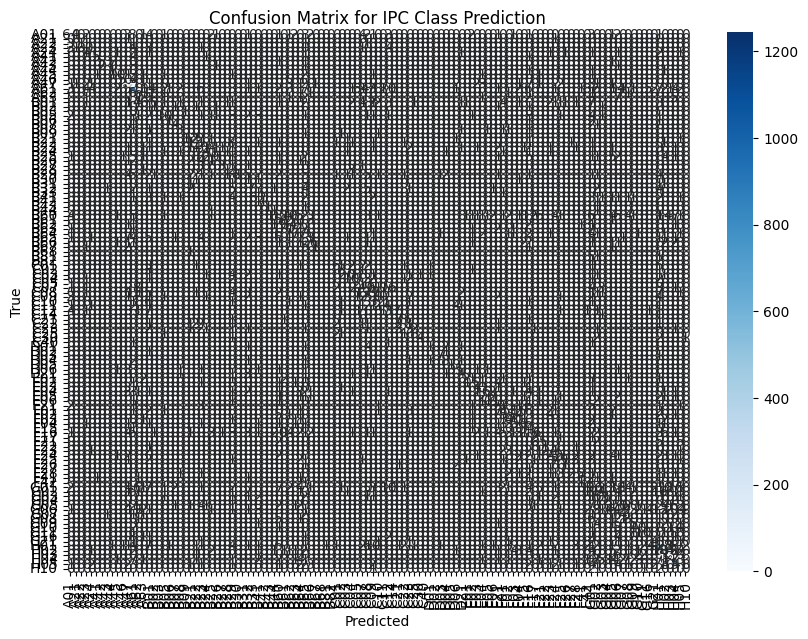

Model saved to Models/ipc_class_classifier.pkl
Label encoder saved to Models/ipc_class_label_encoder.pkl


In [10]:
# Load the dataset (limit to 50,000 rows)
file_path = 'train_dataset.csv'
df = pd.read_csv(file_path, nrows=50000)

# Initialize the SentenceTransformer model
model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')

# Remove rows where the 'claims' column is empty (NaN or empty string)
df = df[df['claims'].notna() & (df['claims'].str.strip() != '')]

# Extract the first 3 characters of the IPC code for class prediction
df['ipc_class'] = df['ipc'].apply(lambda x: x[:3] if pd.notna(x) and len(x) >= 3 else '')

# Encode labels for IPC class
label_encoder_class = LabelEncoder()
df['encoded_class'] = label_encoder_class.fit_transform(df['ipc_class'])

num_classes = len(label_encoder_class.classes_)
print("Number of Encoded Classes:", num_classes)

# Train/test split (for class prediction as an example)
X_train, X_test, y_train, y_test = train_test_split(df['claims'], df['encoded_class'], test_size=0.2, random_state=42)

# Encode the claims into embeddings using PatentSBERTa
X_train_embeddings = model.encode(X_train.tolist())
X_test_embeddings = model.encode(X_test.tolist())

# Convert embeddings to NumPy arrays
X_train_embeddings = np.array(X_train_embeddings)
X_test_embeddings = np.array(X_test_embeddings)

# Checkpoint file paths
checkpoint_classifier_file = 'Models/checkpoint_ipc_class_classifier.pkl'
checkpoint_metrics_file = 'Models/checkpoint_ipc_class_metrics.pkl'
checkpoint_fold_file = 'Models/checkpoint_ipc_class_current_fold.pkl'

# Initialize classifier
classifier = LogisticRegression(max_iter=1000)

# Load checkpoints if available
current_fold = 0
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

if os.path.exists(checkpoint_fold_file):
    current_fold = joblib.load(checkpoint_fold_file)
    accuracy_list, precision_list, recall_list, f1_list = joblib.load(checkpoint_metrics_file)
    classifier = joblib.load(checkpoint_classifier_file)
    print(f"Resuming from fold {current_fold + 1}")

# Cross-validation to simulate training in folds (like epochs)
skf = StratifiedKFold(n_splits=5)

# Train and evaluate the model for each fold
for fold, (train_index, test_index) in enumerate(skf.split(X_train_embeddings, y_train)):
    if fold < current_fold:
        continue  # Skip already completed folds

    X_train_fold, X_test_fold = X_train_embeddings[train_index], X_train_embeddings[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    classifier.fit(X_train_fold, y_train_fold)
    y_pred_fold = classifier.predict(X_test_fold)

    # Calculate metrics for the current fold
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    precision = precision_score(y_test_fold, y_pred_fold, average='weighted')
    recall = recall_score(y_test_fold, y_pred_fold, average='weighted')
    f1 = f1_score(y_test_fold, y_pred_fold, average='weighted')

    # Append metrics to lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    # Save checkpoints after each fold
    joblib.dump(classifier, checkpoint_classifier_file)
    joblib.dump([accuracy_list, precision_list, recall_list, f1_list], checkpoint_metrics_file)
    joblib.dump(fold, checkpoint_fold_file)

    print(f"Fold {fold + 1} completed and checkpoint saved.")

# Visualizing Metrics
epochs = range(1, len(accuracy_list) + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs, accuracy_list, label='Accuracy', marker='o')
plt.plot(epochs, precision_list, label='Precision', marker='o')
plt.plot(epochs, recall_list, label='Recall', marker='o')
plt.plot(epochs, f1_list, label='F1-score', marker='o')
plt.xlabel('Fold (Simulating Epochs)')
plt.ylabel('Metric Value')
plt.title('Training Metrics Over Cross-Validation Folds (IPC Class Prediction)')
plt.legend()
plt.grid(True)
plt.show()

# Final evaluation on the test set
classifier.fit(X_train_embeddings, y_train)
y_pred = classifier.predict(X_test_embeddings)

# Compute final metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1-score: {f1}")


 # Get the unique classes in the test set
test_labels = np.unique(y_test)

# Classification report
print(classification_report(y_test, y_pred, labels=test_labels, target_names=label_encoder_class.inverse_transform(test_labels)))

# Confusion matrix for final evaluation
cm = confusion_matrix(y_test, y_pred, labels=test_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder_class.inverse_transform(test_labels), yticklabels=label_encoder_class.inverse_transform(test_labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for IPC Class Prediction')
plt.show()


# Save the final classifier
classifier_file_path = 'Models/ipc_class_classifier.pkl'
joblib.dump(classifier, classifier_file_path)

# Save the label encoder for the IPC classes
label_encoder_file_path = 'Models/ipc_class_label_encoder.pkl'
joblib.dump(label_encoder_class, label_encoder_file_path)

# Remove the checkpoint files after successful completion
if os.path.exists(checkpoint_fold_file):
    os.remove(checkpoint_fold_file)
if os.path.exists(checkpoint_classifier_file):
    os.remove(checkpoint_classifier_file)
if os.path.exists(checkpoint_metrics_file):
    os.remove(checkpoint_metrics_file)

print(f"Model saved to {classifier_file_path}")
print(f"Label encoder saved to {label_encoder_file_path}")


In [11]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import joblib

### Step 1: Extract IPC Class from Dataset and Save to CSV

# Load the original dataset
file_path = 'eval_dataset.csv'
df = pd.read_csv(file_path)

# Extract the first 3 characters of the IPC code for IPC class
df['ipc_class'] = df['ipc'].apply(lambda x: x[:3] if pd.notna(x) and len(x) >= 3 else '')

# Save the dataset with the extracted IPC class to a new CSV file
extracted_class_file_path = 'extracted_ipc_class_dataset.csv'
df.to_csv(extracted_class_file_path, index=False)

print(f"Extracted IPC class dataset saved to {extracted_class_file_path}")

# Display the first few rows to verify
print(df.head(10))


### Step 2: Use Extracted IPC Class Dataset to Evaluate Prediction

# Load the trained model and encoders for IPC class
classifier = joblib.load('Models/ipc_class_classifier.pkl')
label_encoder_class = joblib.load('Models/ipc_class_label_encoder.pkl')

# Load the dataset with extracted IPC class (from step 1)
eval_file_path = 'extracted_ipc_class_dataset.csv'
eval_df = pd.read_csv(eval_file_path)

# Initialize the SentenceTransformer model (PatentSBERTa)
model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')

# Remove rows where the 'claims' column is empty (NaN or empty string)
eval_df = eval_df[eval_df['claims'].notna() & (eval_df['claims'].str.strip() != '')]

# Encode the 'claims' from eval_dataset.csv into embeddings
eval_claims_embeddings = model.encode(eval_df['claims'].tolist())

# Use the trained classifier to predict the IPC class
predicted_encoded_classes = classifier.predict(eval_claims_embeddings)

# Decode the predicted classes back to their original IPC class format
predicted_classes = label_encoder_class.inverse_transform(predicted_encoded_classes)

# Add the predicted classes and check if predictions are correct
eval_df['predicted_class'] = predicted_classes
eval_df['correct_prediction'] = eval_df['predicted_class'] == eval_df['ipc_class']

# Display the DataFrame showing publication_number, ipc, claims, actual ipc_class, and predicted_class
result_df = eval_df[['publication_number', 'ipc', 'claims', 'ipc_class', 'predicted_class', 'correct_prediction']]

# Display the DataFrame with the results
print(result_df.head(10))  # Show first 10 rows

# Calculate and display the accuracy
correct_predictions = result_df['correct_prediction'].sum()
total_predictions = len(result_df)
accuracy = correct_predictions / total_predictions

print(f"\nTotal predictions: {total_predictions}")
print(f"Correct predictions: {correct_predictions}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Save the result to a new CSV file
result_file_path = 'predicted_eval_dataset_class.csv'
result_df.to_csv(result_file_path, index=False)

print(f"\nResults saved to {result_file_path}")

# Optional: Show the first 100 rows of the saved file
print(result_df.head(100))


Extracted IPC class dataset saved to extracted_ipc_class_dataset.csv
   publication_number                                                ipc  \
0             3048899  A23J1/00, C07K1/22, C07K16/00, C07K17/00, G01N...   
1             3060940  G01S7/03, H01Q21/08, G01S13/42, G01S13/34, G01...   
2             3751677  H01R13/52, H01R13/6581, H05K5/02, H01R12/72, H...   
3             3887488  C10L1/224, C10L10/04, C10L10/06, C10L10/08, C1...   
4             3268037                              A61K39/395, C07K16/28   
5             3569771                      E02F3/32, E02F9/20, G05G9/047   
6             3401761                      H04L12/28, G06F3/16, G06F3/01   
7             3448922  C08J3/20, C09D5/34, C09D183/06, C09D183/08, B0...   
8             3738946             C07C7/00, C07C7/04, C07C7/12, C07C9/15   
9             3595293                               H04N5/357, H04N5/378   

                                              claims ipc_section ipc_class  
0  a method of in

# Train for IPC subclass prediction

Number of Encoded Subclasses: 585


/home/sahaarnab013/.conda/envs/testenv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/sahaarnab013/.conda/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 completed and checkpoint saved.


/home/sahaarnab013/.conda/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 completed and checkpoint saved.


/home/sahaarnab013/.conda/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 completed and checkpoint saved.


/home/sahaarnab013/.conda/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4 completed and checkpoint saved.


/home/sahaarnab013/.conda/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 5 completed and checkpoint saved.


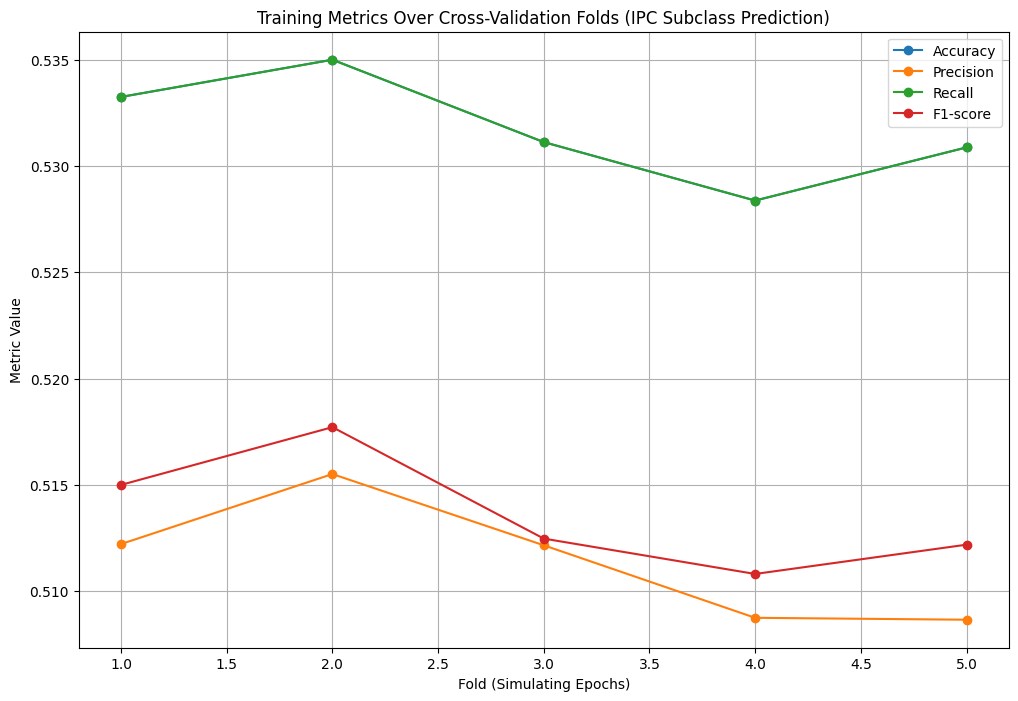

/home/sahaarnab013/.conda/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sahaarnab013/.conda/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sahaarnab013/.conda/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capit

Test Accuracy: 0.5449
Test Precision: 0.5288421395726663
Test Recall: 0.5449
Test F1-score: 0.5293896714224978
              precision    recall  f1-score   support

        A01B       0.11      0.17      0.13         6
        A01C       1.00      0.33      0.50         9
        A01D       0.55      0.55      0.55        20
        A01F       0.67      0.55      0.60        11
        A01G       0.19      0.30      0.23        10
        A01H       1.00      0.40      0.57         5
        A01J       1.00      0.50      0.67         4
        A01K       0.43      0.50      0.47        20
        A01M       0.50      0.17      0.25         6
        A01N       0.50      0.50      0.50        24
        A01P       0.00      0.00      0.00         3
        A21B       0.00      0.00      0.00         2
        A21C       0.00      0.00      0.00         2
        A21D       0.00      0.00      0.00         1
        A22B       0.00      0.00      0.00         2
        A22C       1.00 

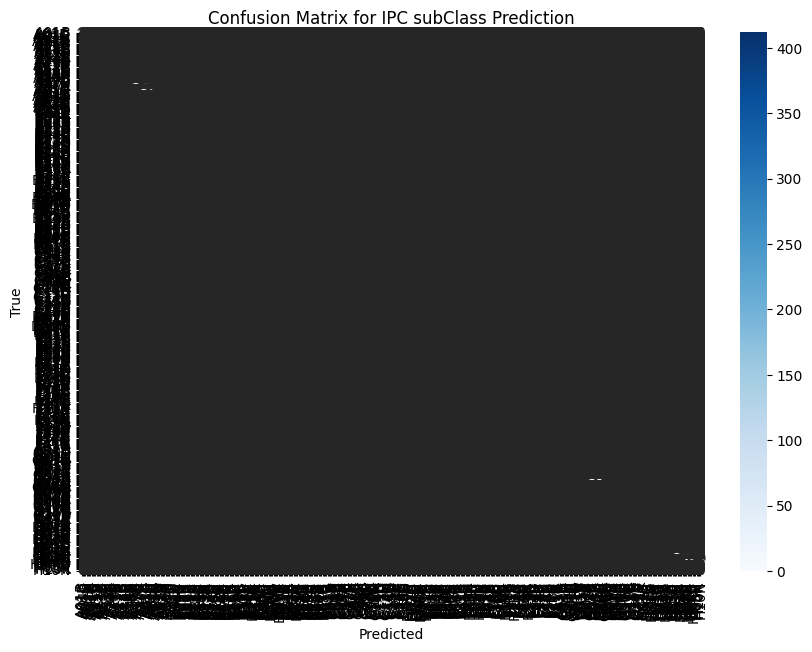

Model saved to Models/ipc_subclass_classifier.pkl
Label encoder saved to Models/ipc_subclass_label_encoder.pkl


In [12]:
# Load the dataset (limit to 50,000 rows)
file_path = 'train_dataset.csv'
df = pd.read_csv(file_path, nrows=50000)

# Initialize the SentenceTransformer model
model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')

# Remove rows where the 'claims' column is empty (NaN or empty string)
df = df[df['claims'].notna() & (df['claims'].str.strip() != '')]

# Extract the first 4 characters of the IPC code for subclass prediction
df['ipc_subclass'] = df['ipc'].apply(lambda x: x[:4] if pd.notna(x) and len(x) >= 4 else '')

# Encode labels for IPC subclass
label_encoder_subclass = LabelEncoder()
df['encoded_subclass'] = label_encoder_subclass.fit_transform(df['ipc_subclass'])

num_subclasses = len(label_encoder_subclass.classes_)
print("Number of Encoded Subclasses:", num_subclasses)

# Train/test split (for subclass prediction as an example)
X_train, X_test, y_train, y_test = train_test_split(df['claims'], df['encoded_subclass'], test_size=0.2, random_state=42)

# Encode the claims into embeddings using PatentSBERTa
X_train_embeddings = model.encode(X_train.tolist())
X_test_embeddings = model.encode(X_test.tolist())

# Convert embeddings to NumPy arrays
X_train_embeddings = np.array(X_train_embeddings)
X_test_embeddings = np.array(X_test_embeddings)

# Checkpoint file paths
checkpoint_classifier_file = 'Models/checkpoint_ipc_subclass_classifier.pkl'
checkpoint_metrics_file = 'Models/checkpoint_ipc_subclass_metrics.pkl'
checkpoint_fold_file = 'Models/checkpoint_ipc_subclass_current_fold.pkl'

# Initialize classifier
classifier = LogisticRegression(max_iter=1000)

# Load checkpoints if available
current_fold = 0
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

if os.path.exists(checkpoint_fold_file):
    current_fold = joblib.load(checkpoint_fold_file)
    accuracy_list, precision_list, recall_list, f1_list = joblib.load(checkpoint_metrics_file)
    classifier = joblib.load(checkpoint_classifier_file)
    print(f"Resuming from fold {current_fold + 1}")

# Cross-validation to simulate training in folds (like epochs)
skf = StratifiedKFold(n_splits=5)

# Train and evaluate the model for each fold
for fold, (train_index, test_index) in enumerate(skf.split(X_train_embeddings, y_train)):
    if fold < current_fold:
        continue  # Skip already completed folds

    X_train_fold, X_test_fold = X_train_embeddings[train_index], X_train_embeddings[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    classifier.fit(X_train_fold, y_train_fold)
    y_pred_fold = classifier.predict(X_test_fold)

    # Calculate metrics for the current fold
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    precision = precision_score(y_test_fold, y_pred_fold, average='weighted')
    recall = recall_score(y_test_fold, y_pred_fold, average='weighted')
    f1 = f1_score(y_test_fold, y_pred_fold, average='weighted')

    # Append metrics to lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    # Save checkpoints after each fold
    joblib.dump(classifier, checkpoint_classifier_file)
    joblib.dump([accuracy_list, precision_list, recall_list, f1_list], checkpoint_metrics_file)
    joblib.dump(fold, checkpoint_fold_file)

    print(f"Fold {fold + 1} completed and checkpoint saved.")

# Visualizing Metrics
epochs = range(1, len(accuracy_list) + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs, accuracy_list, label='Accuracy', marker='o')
plt.plot(epochs, precision_list, label='Precision', marker='o')
plt.plot(epochs, recall_list, label='Recall', marker='o')
plt.plot(epochs, f1_list, label='F1-score', marker='o')
plt.xlabel('Fold (Simulating Epochs)')
plt.ylabel('Metric Value')
plt.title('Training Metrics Over Cross-Validation Folds (IPC Subclass Prediction)')
plt.legend()
plt.grid(True)
plt.show()

# Final evaluation on the test set
classifier.fit(X_train_embeddings, y_train)
y_pred = classifier.predict(X_test_embeddings)

# Compute final metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1-score: {f1}")


# Get the unique classes in the test set
test_labels = np.unique(y_test)

# Classification report
print(classification_report(y_test, y_pred, labels=test_labels, target_names=label_encoder_subclass.inverse_transform(test_labels)))

# Confusion matrix for final evaluation
cm = confusion_matrix(y_test, y_pred, labels=test_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder_subclass.inverse_transform(test_labels), yticklabels=label_encoder_subclass.inverse_transform(test_labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for IPC subClass Prediction')
plt.show()

# Save the final classifier
classifier_file_path = 'Models/ipc_subclass_classifier.pkl'
joblib.dump(classifier, classifier_file_path)

# Save the label encoder for the IPC subclasses
label_encoder_file_path = 'Models/ipc_subclass_label_encoder.pkl'
joblib.dump(label_encoder_subclass, label_encoder_file_path)

# Remove the checkpoint files after successful completion
if os.path.exists(checkpoint_fold_file):
    os.remove(checkpoint_fold_file)
if os.path.exists(checkpoint_classifier_file):
    os.remove(checkpoint_classifier_file)
if os.path.exists(checkpoint_metrics_file):
    os.remove(checkpoint_metrics_file)

print(f"Model saved to {classifier_file_path}")
print(f"Label encoder saved to {label_encoder_file_path}")


In [13]:
# Load the trained model and encoders for IPC subclass
classifier = joblib.load('Models/ipc_subclass_classifier.pkl')
label_encoder_subclass = joblib.load('Models/ipc_subclass_label_encoder.pkl')

# Load the evaluation dataset
eval_file_path = 'eval_dataset.csv'
eval_df = pd.read_csv(eval_file_path)

# Initialize the SentenceTransformer model (PatentSBERTa)
model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')

# Remove rows where the 'claims' column is empty (NaN or empty string)
eval_df = eval_df[eval_df['claims'].notna() & (eval_df['claims'].str.strip() != '')]

# Extract the first 4 characters of the IPC code for subclass prediction and add it to the DataFrame
eval_df['ipc_subclass'] = eval_df['ipc'].apply(lambda x: x[:4] if pd.notna(x) and len(x) >= 4 else '')

# Save the updated DataFrame with IPC subclass included
updated_eval_file_path = 'eval_dataset.csv'
eval_df.to_csv(updated_eval_file_path, index=False)

print(f"\nUpdated evaluation dataset saved to {updated_eval_file_path}")

# Encode the 'claims' from eval_dataset.csv into embeddings
eval_claims_embeddings = model.encode(eval_df['claims'].tolist())

# Use the trained classifier to predict the IPC subclass
predicted_encoded_subclasses = classifier.predict(eval_claims_embeddings)

# Decode the predicted subclasses back to their original IPC subclass format
predicted_subclasses = label_encoder_subclass.inverse_transform(predicted_encoded_subclasses)

# Add the predicted subclasses and check if predictions are correct
eval_df['predicted_subclass'] = predicted_subclasses
eval_df['correct_prediction'] = eval_df['predicted_subclass'] == eval_df['ipc_subclass']

# Display the DataFrame showing publication_number, ipc, claims, actual ipc_subclass, and predicted_subclass
result_df = eval_df[['publication_number', 'ipc', 'claims', 'ipc_subclass', 'predicted_subclass', 'correct_prediction']]

# Display the DataFrame with the results
print(result_df.head(10))  # Show first 10 rows

# Calculate and display the accuracy
correct_predictions = result_df['correct_prediction'].sum()
total_predictions = len(result_df)
accuracy = correct_predictions / total_predictions

print(f"\nTotal predictions: {total_predictions}")
print(f"Correct predictions: {correct_predictions}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Save the result to a new CSV file
result_file_path = 'predicted_eval_subclass_dataset.csv'
result_df.to_csv(result_file_path, index=False)

print(f"\nResults saved to {result_file_path}")

# Optional: Show the first 10 rows of the saved file
result_df.head(10)



Updated evaluation dataset saved to eval_dataset.csv
   publication_number                                                ipc  \
0             3048899  A23J1/00, C07K1/22, C07K16/00, C07K17/00, G01N...   
1             3060940  G01S7/03, H01Q21/08, G01S13/42, G01S13/34, G01...   
2             3751677  H01R13/52, H01R13/6581, H05K5/02, H01R12/72, H...   
3             3887488  C10L1/224, C10L10/04, C10L10/06, C10L10/08, C1...   
4             3268037                              A61K39/395, C07K16/28   
5             3569771                      E02F3/32, E02F9/20, G05G9/047   
6             3401761                      H04L12/28, G06F3/16, G06F3/01   
7             3448922  C08J3/20, C09D5/34, C09D183/06, C09D183/08, B0...   
8             3738946             C07C7/00, C07C7/04, C07C7/12, C07C9/15   
9             3595293                               H04N5/357, H04N5/378   

                                              claims ipc_subclass  \
0  a method of inactivating virus presen

,publication_number,ipc,claims,ipc_subclass,predicted_subclass,correct_prediction
0,3048899,"A23J1/00, C07K1/22, C07K16/00, C07K17/00, G01N...",a method of inactivating virus present during ...,A23J,C07K,False
1,3060940,"G01S7/03, H01Q21/08, G01S13/42, G01S13/34, G01...",a radar apparatus for estimating position of a...,G01S,G01S,True
2,3751677,"H01R13/52, H01R13/6581, H05K5/02, H01R12/72, H...",an electronic component unit 1 comprisinga cir...,H01R,H05K,False
3,3887488,"C10L1/224, C10L10/04, C10L10/06, C10L10/08, C1...","a fuel composition comprisingi a liquid fuel, ...",C10L,C10L,True
4,3268037,"A61K39/395, C07K16/28",a cd27 agonist comprising a first component th...,A61K,C07K,False
5,3569771,"E02F3/32, E02F9/20, G05G9/047",a working machine 100 comprisinga body 104a wo...,E02F,B25J,False
6,3401761,"H04L12/28, G06F3/16, G06F3/01",an information processing device 100 comprisin...,H04L,G06F,False
7,3448922,"C08J3/20, C09D5/34, C09D183/06, C09D183/08, B0...",a method for the production of a moisture cura...,C08J,C08J,True
8,3738946,"C07C7/00, C07C7/04, C07C7/12, C07C9/15",an nheptane production method comprisinga step...,C07C,C07C,True
9,3595293,"H04N5/357, H04N5/378","an image sensor system, comprisinga matrix hav...",H04N,H04N,True


# Compare between Section, Class and Subclass

/home/sahaarnab013/.conda/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sahaarnab013/.conda/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sahaarnab013/.conda/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capit

Metrics for IPC Section Prediction:
Accuracy: 0.72, Precision: 0.72, Recall: 0.72, F1-score: 0.72
Metrics for IPC Class Prediction:
Accuracy: 0.64, Precision: 0.64, Recall: 0.64, F1-score: 0.64
Metrics for IPC Subclass Prediction:
Accuracy: 0.54, Precision: 0.53, Recall: 0.54, F1-score: 0.52


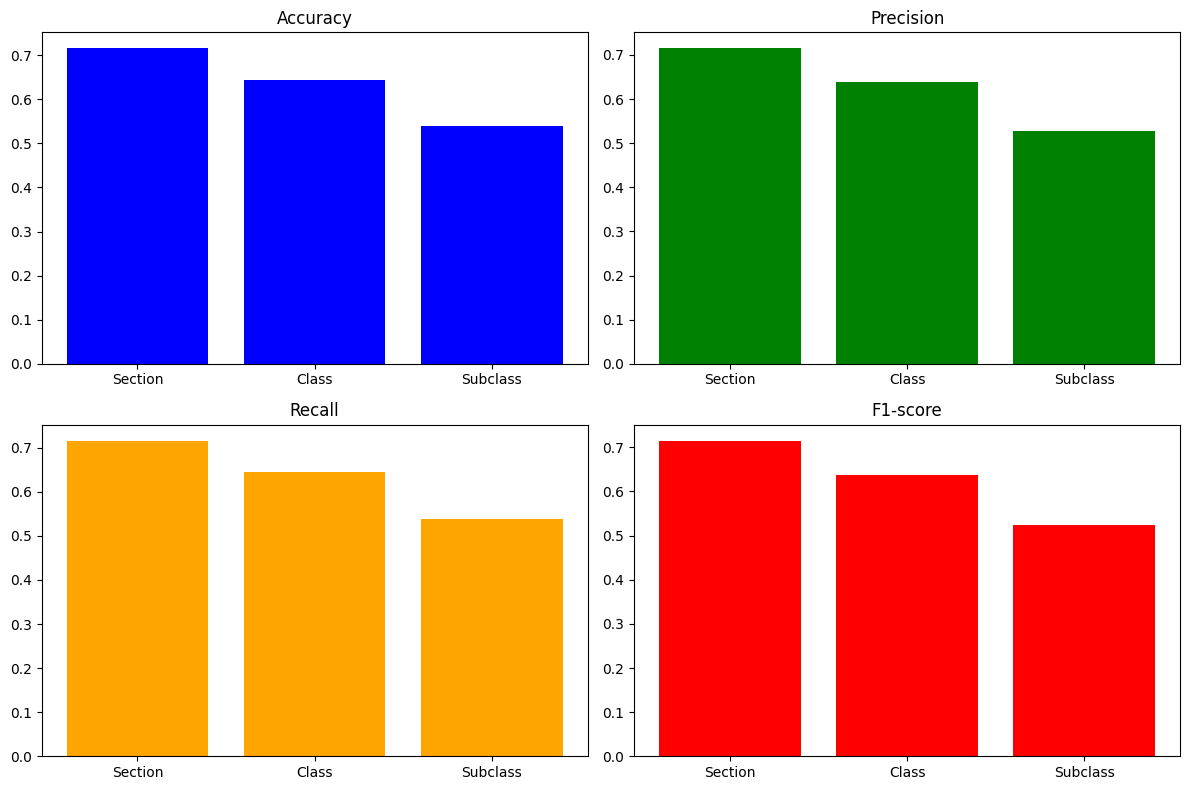

In [14]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import matplotlib.pyplot as plt

# Load the evaluation dataset
eval_file_path = 'eval_dataset.csv'
eval_df = pd.read_csv(eval_file_path)

# Extract IPC section, class, and subclass
eval_df['ipc_section'] = eval_df['ipc'].apply(lambda x: x[0] if pd.notna(x) and len(x) > 0 else '')
eval_df['ipc_class'] = eval_df['ipc'].apply(lambda x: x[:3] if pd.notna(x) and len(x) >= 3 else '')
eval_df['ipc_subclass'] = eval_df['ipc'].apply(lambda x: x[:4] if pd.notna(x) and len(x) >= 4 else '')

# Initialize the SentenceTransformer model (PatentSBERTa)
model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')

# Remove rows where the 'claims' column is empty (NaN or empty string)
eval_df = eval_df[eval_df['claims'].notna() & (eval_df['claims'].str.strip() != '')]

# Encode the 'claims' from eval_dataset.csv into embeddings
eval_claims_embeddings = model.encode(eval_df['claims'].tolist())

### Load the trained models and encoders for IPC section, class, and subclass ###
# IPC Section
classifier_section = joblib.load('Models/ipc_section_classifier.pkl')
label_encoder_section = joblib.load('Models/ipc_section_label_encoder.pkl')

# IPC Class
classifier_class = joblib.load('Models/ipc_class_classifier.pkl')
label_encoder_class = joblib.load('Models/ipc_class_label_encoder.pkl')

# IPC Subclass
classifier_subclass = joblib.load('Models/ipc_subclass_classifier.pkl')
label_encoder_subclass = joblib.load('Models/ipc_subclass_label_encoder.pkl')

### Section Prediction ###
predicted_encoded_sections = classifier_section.predict(eval_claims_embeddings)
predicted_sections = label_encoder_section.inverse_transform(predicted_encoded_sections)

# Metrics for Section
accuracy_section = accuracy_score(eval_df['ipc_section'], predicted_sections)
precision_section = precision_score(eval_df['ipc_section'], predicted_sections, average='weighted')
recall_section = recall_score(eval_df['ipc_section'], predicted_sections, average='weighted')
f1_section = f1_score(eval_df['ipc_section'], predicted_sections, average='weighted')

### Class Prediction ###
predicted_encoded_classes = classifier_class.predict(eval_claims_embeddings)
predicted_classes = label_encoder_class.inverse_transform(predicted_encoded_classes)

# Metrics for Class
accuracy_class = accuracy_score(eval_df['ipc_class'], predicted_classes)
precision_class = precision_score(eval_df['ipc_class'], predicted_classes, average='weighted')
recall_class = recall_score(eval_df['ipc_class'], predicted_classes, average='weighted')
f1_class = f1_score(eval_df['ipc_class'], predicted_classes, average='weighted')

### Subclass Prediction ###
predicted_encoded_subclasses = classifier_subclass.predict(eval_claims_embeddings)
predicted_subclasses = label_encoder_subclass.inverse_transform(predicted_encoded_subclasses)

# Metrics for Subclass
accuracy_subclass = accuracy_score(eval_df['ipc_subclass'], predicted_subclasses)
precision_subclass = precision_score(eval_df['ipc_subclass'], predicted_subclasses, average='weighted')
recall_subclass = recall_score(eval_df['ipc_subclass'], predicted_subclasses, average='weighted')
f1_subclass = f1_score(eval_df['ipc_subclass'], predicted_subclasses, average='weighted')

### Print and Compare Metrics ###
print(f"Metrics for IPC Section Prediction:\nAccuracy: {accuracy_section:.2f}, Precision: {precision_section:.2f}, Recall: {recall_section:.2f}, F1-score: {f1_section:.2f}")
print(f"Metrics for IPC Class Prediction:\nAccuracy: {accuracy_class:.2f}, Precision: {precision_class:.2f}, Recall: {recall_class:.2f}, F1-score: {f1_class:.2f}")
print(f"Metrics for IPC Subclass Prediction:\nAccuracy: {accuracy_subclass:.2f}, Precision: {precision_subclass:.2f}, Recall: {recall_subclass:.2f}, F1-score: {f1_subclass:.2f}")

### Visualize Metrics for Comparison ###
labels = ['Section', 'Class', 'Subclass']
accuracy_values = [accuracy_section, accuracy_class, accuracy_subclass]
precision_values = [precision_section, precision_class, precision_subclass]
recall_values = [recall_section, recall_class, recall_subclass]
f1_values = [f1_section, f1_class, f1_subclass]

x = range(len(labels))

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.bar(x, accuracy_values, color='blue')
plt.xticks(x, labels)
plt.title('Accuracy')

plt.subplot(2, 2, 2)
plt.bar(x, precision_values, color='green')
plt.xticks(x, labels)
plt.title('Precision')

plt.subplot(2, 2, 3)
plt.bar(x, recall_values, color='orange')
plt.xticks(x, labels)
plt.title('Recall')

plt.subplot(2, 2, 4)
plt.bar(x, f1_values, color='red')
plt.xticks(x, labels)
plt.title('F1-score')

plt.tight_layout()
plt.show()
